**Candidate name: Sneha Santha Prabakar**

**Week 6: PPO Experimentation**

An AI agent learns to balance a simulated pole on a cart by moving the cart left or right.

The agent is rewarded for each step it takes to keep the pole upright for as long as possible.

The exercise ends when the pole falls, or the cart moves too far from the centre point.

- Goal: Keep the pole balanced upright by moving the cart left or right
  - So every **action** the agent takes is trying to:
    - Prevent the pole from tipping too far
    - Keep the cart going off the track
  - The agent gets **+1 reward** for every time step the pole remains balanced and the cart is within bounds
- Number of steps per epoch: 4,000
- Episode: One try/run of the agent
  - Begins when the agen starts from the beginning of the environment
  - Ends when:
    - The poll falls - indicated if the pole's angle exceeds a certain threshold; e.g. +- 12 degrees from vertical)
    - The cart moves too far from the center
    - It reaches the max steps (4,000) - Then it did perfectly!
  - Here, One episode = one attempt to balance the pole for as long as possible
- Epoch: One training cycle
  - How often the agent updates its neural network using the data it just collected
  - During each epoch:
    - The agent plays many episodes (to collect experience), then it calculates **advantage** (how good certain actions were) and then updates policy.
    - Then it uses that data to update its policy (learning step)
    - The number of episodes per epoch is variable - it depends on how long the agent survives in each episode. In each epoch, the agent collects 4,000 time steps worth of experience.
      - So it can take 20 episodes (if each episode lasts approximately 200 steps), or even 1 episode (if it lasts the full 4000 steps).
  - Here, the number of epochs is set by the developer (without any early stopping condition)
- Mean return = Average reward per episode (higher=better)
- Mean length = Average number of steps survived per episode
- Here, the reward = number of steps survived


General ways to evaluate the performance of the model (after hyperparameter tuning):
- Higher mean return early --> model learns faster
- Reaches max length (4,000) quickly --> model has mastered the task
- Stable performance after reaching max --> reliable policy
- Less variance in episode returns --> Consistent learning

Hence, the ways to evaluate long-term stability are:
1. Performance over time: Plot the mean return and mean length over all epochs
  - If if plateaus at a high value and stays there - good model
  - If it fluctuates or drops after a few good epochs - bad (over-fitting)
2. [...]




# Import libraries

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal

import matplotlib.pyplot as plt
import pandas as pd

# Functions and Class

In [ ]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a, num_actions):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, tf.cast(num_actions, tf.int32)) * logprobabilities_all, axis=1
    )
    return logprobability


seed_generator = keras.random.SeedGenerator(1337)


# Sample action from actor
@tf.function
def sample_action(observation, actor):
    logits = actor(observation)
    action = keras.ops.squeeze(
        keras.random.categorical(logits, 1, seed=seed_generator), axis=1
    )
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer,
    actor, clip_ratio, policy_optimizer, num_actions
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = keras.ops.exp(
            logprobabilities(actor(observation_buffer), action_buffer, num_actions)
            - logprobability_buffer
        )
        min_advantage = keras.ops.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -keras.ops.mean(
            keras.ops.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = keras.ops.mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer, num_actions)
    )
    kl = keras.ops.sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer, critic, value_optimizer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

# Hyperparameters tuning

In [ ]:
# # Hyperparameters of the PPO algorithm
# steps_per_epoch = 4000
# epochs = 5
# gamma = 0.99
# clip_ratio = 0.2
# policy_learning_rate = 3e-4
# value_function_learning_rate = 1e-3
# train_policy_iterations = 80
# train_value_iterations = 80
# lam = 0.97
# target_kl = 0.01
# hidden_sizes = (64, 64)

# # True if you want to render the environment
# render = False

# Initialization + Training

In [ ]:
def plot_experiment(log, title="Experiment0"):
    plt.figure(figsize=(8, 5))
    plt.plot(log['epoch'], log['mean_return'], label='Mean Return', color='blue')
    plt.plot(log['epoch'], log['mean_length'], label='Mean Episode Length', color='red', linestyle='--')
    plt.title(f"{title}")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def run_experiment(epochs=30, hidden_sizes=(64,64), clip_ratio=0.2, experiment_name="exp0"):

  # Hyperparameters of the PPO algorithm
  steps_per_epoch = 4000
  # epochs = 30
  gamma = 0.99
  # clip_ratio = 0.2
  policy_learning_rate = 3e-4
  value_function_learning_rate = 1e-3
  train_policy_iterations = 80
  train_value_iterations = 80
  lam = 0.97
  target_kl = 0.01
  # hidden_sizes = (64, 64)

  # True if you want to render the environment
  render = False

  # Initialize the environment and get the dimensionality of the
  # observation space and the number of possible actions
  env = gym.make("CartPole-v1")
  observation_dimensions = env.observation_space.shape[0]
  num_actions = env.action_space.n

  # Initialize the buffer
  buffer = Buffer(observation_dimensions, steps_per_epoch)

  # Initialize the actor and the critic as keras models
  observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
  logits = mlp(observation_input, list(hidden_sizes) + [num_actions])
  actor = keras.Model(inputs=observation_input, outputs=logits)
  value = keras.ops.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
  critic = keras.Model(inputs=observation_input, outputs=value)

  # Initialize the policy and the value function optimizers
  policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
  value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

  # Initialize the observation, episode return and episode length
  observation, _ = env.reset()
  episode_return, episode_length = 0, 0

  log_data = []  # Empty list to store epoch logs

  print(f"Running {experiment_name}\n")

  # Iterate over the number of epochs
  for epoch in range(epochs):
      # Initialize the sum of the returns, lengths and number of episodes for each epoch
      sum_return = 0
      sum_length = 0
      num_episodes = 0

      # Iterate over the steps of each epoch
      for t in range(steps_per_epoch):
          if render:
              env.render()

          # Get the logits, action, and take one step in the environment
          observation = observation.reshape(1, -1)
          logits, action = sample_action(observation, actor)
          observation_new, reward, done, _, _ = env.step(action[0].numpy())
          episode_return += reward
          episode_length += 1

          # Get the value and log-probability of the action
          value_t = critic(observation)
          logprobability_t = logprobabilities(logits, action, num_actions)

          # Store obs, act, rew, v_t, logp_pi_t
          buffer.store(observation, action, reward, value_t, logprobability_t)

          # Update the observation
          observation = observation_new

          # Finish trajectory if reached to a terminal state
          terminal = done
          if terminal or (t == steps_per_epoch - 1):
              last_value = 0 if done else critic(observation.reshape(1, -1))
              buffer.finish_trajectory(last_value)
              sum_return += episode_return
              sum_length += episode_length
              num_episodes += 1
              observation, _ = env.reset()
              episode_return, episode_length = 0, 0


      # Get values from the buffer
      (
          observation_buffer,
          action_buffer,
          advantage_buffer,
          return_buffer,
          logprobability_buffer,
      ) = buffer.get()

      # Update the policy and implement early stopping using KL divergence
      for _ in range(train_policy_iterations):
          kl = train_policy(
              observation_buffer, action_buffer, logprobability_buffer, advantage_buffer,
              actor, clip_ratio, policy_optimizer, num_actions
          )
          if kl > 1.5 * target_kl:
              # Early Stopping
              break

      # Update the value function
      for _ in range(train_value_iterations):
          train_value_function(observation_buffer, return_buffer, critic, value_optimizer)

      mean_return = sum_return / num_episodes
      mean_length = sum_length / num_episodes

      log_data.append({
          'epoch': epoch + 1,
          'mean_return': mean_return,
          'mean_length': mean_length
      })


      # Print mean return and length for each epoch
      print(
          f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
      )

  log_df = pd.DataFrame(log_data)
  plot_experiment(log_df, title=experiment_name)


Running Experiment 1

 Epoch: 1. Mean Return: 17.467248908296945. Mean Length: 17.467248908296945
 Epoch: 2. Mean Return: 21.85792349726776. Mean Length: 21.85792349726776
 Epoch: 3. Mean Return: 27.397260273972602. Mean Length: 27.397260273972602
 Epoch: 4. Mean Return: 38.095238095238095. Mean Length: 38.095238095238095
 Epoch: 5. Mean Return: 62.5. Mean Length: 62.5


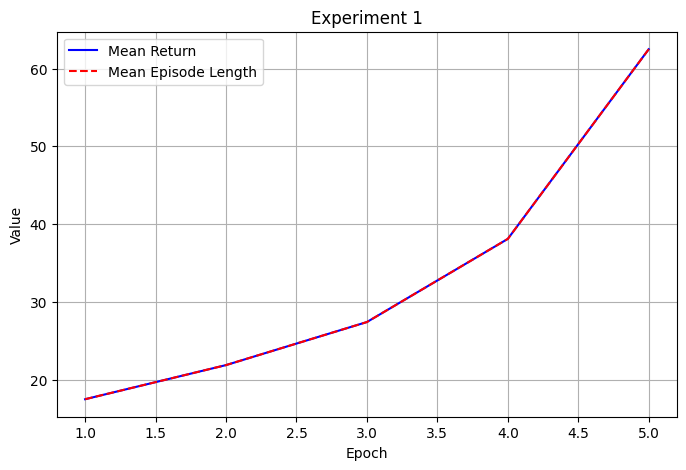

In [ ]:
# Experiment 1: Reduce Training Epochs

# epochs = 5

# Qs: Is the agent improving meaningfully by epoch 5?

run_experiment(epochs=5, hidden_sizes=(64,64), clip_ratio=0.2 ,experiment_name="Experiment 1")

In [ ]:
# Experiment 2: Increase Hidden Layer Size

# hidden_sizes = (128, 128)
# epochs = 5

# Qs: Any noticeable improvement in convergence speed or return?

run_experiment(epochs=5, hidden_sizes=(128, 128), clip_ratio=0.2 ,experiment_name="Experiment 2")

Running Experiment 2



ValueError: in user code:

    File "<ipython-input-2-86cb5d89f6c6>", line 115, in train_policy  *
        policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 422, in apply
        self.build(trainable_variables)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 97, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 35, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 319, in add_variable_from_reference
        return self.add_variable(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 274, in add_variable
        variable = backend.Variable(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/common/variables.py", line 186, in __init__
        self._initialize_with_initializer(initializer)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 47, in _initialize_with_initializer
        self._initialize(lambda: initializer(self._shape, dtype=self._dtype))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/core.py", line 38, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [ ]:
# Experiment 3: Increase Clip Ratio

# clip_ratio = 0.4
# hidden_sizes = (64, 64) -- default
# epochs = 5

# Qs: Is learning faster or more unstable? Any signs of early stopping?

run_experiment(epochs=5, hidden_sizes=(64,64), clip_ratio=0.4 ,experiment_name="Experiment 3")